In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns

In [2]:
bc_covid_data = pd.read_csv("C:\\SFU\\bc_covid_data.csv")
series_data = bc_covid_data['Reported_Date'].value_counts(sort=False)
case_dates = np.array(series_data.keys())
case_frequency = np.array(series_data)

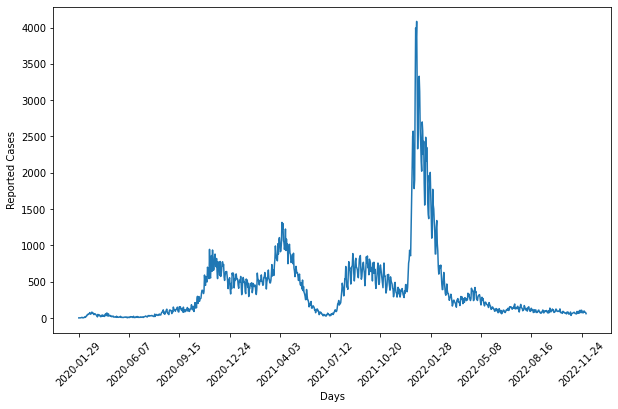

In [6]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(case_dates, case_frequency)
plt.ylabel('Reported Cases')
plt.xlabel('Days')
plt.xticks(case_dates[::100], rotation=45)
plt.show()

# Fitting SIRS Model to initial data

- Susceptible Class: 80% of the entire BC population is assumed to be susceptible to the omicron infection. 
- 50% of cases of Covid-19 on 12th Dec, 2021 is assumed to be from Omicron Infection
- Duration of infection is 5 days
- Immunity from infection is 180 days (Duration of recovered-class)
- Growth rate of about 20% in the initial few days
- Need to tune beta to match the number of cases from Dec 12th, 2021 to Dec 31st, 2021.

2021-12-12 2022-01-01 361


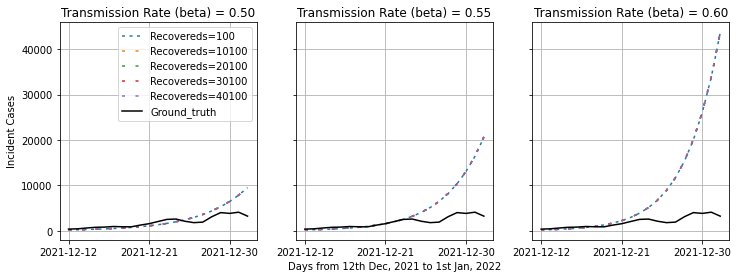

In [4]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 673   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
plt.rcParams['figure.figsize'] = (12, 4)
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
# Fitting SIRS Model

def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    del_S = -beta*S*I/5100000 + R/180
    del_I = beta*S*I/5100000 -I/5 
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0)

index = 0
for beta in [0.5, 0.55, 0.6]:
    for r in range(100, 50000, 10000):
        S0 = 5100000*0.8
        sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), r, beta], t_eval=range(final_date-initial_date+1))
        new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
        #reportable_cases = np.multiply(new_incident_cases, frac_test)
        if(r == 100):
            axs[index].plot(dates_of_interest, new_incident_cases, label='Recovereds=%d' % r, linestyle='dotted', dashes=(2, 3))
        elif(r == 2100):
            axs[index].plot(dates_of_interest, new_incident_cases, label='Recovereds=%d' % r, linestyle='dotted', dashes=(2, 4))
        elif(r == 4100):
            axs[index].plot(dates_of_interest, new_incident_cases, label='Recovereds=%d' % r, linestyle='dotted', dashes=(2, 5))
        elif(r == 6100):
            axs[index].plot(dates_of_interest, new_incident_cases, label='Recovereds=%d' % r, linestyle='dotted', dashes=(2, 6))
        else:
            axs[index].plot(dates_of_interest, new_incident_cases, label='Recovereds=%d' % r, linestyle='dotted', dashes=(2, 7))
    axs[index].plot(dates_of_interest, corresponding_cases, label='Ground_truth', color='black')
    axs[index].set(title='Transmission Rate (beta) = %.2f' % beta)
    if(index==0):
        axs[index].set(ylabel='Incident Cases', xticks=dates_of_interest[::9])
        axs[index].legend()
    if(index==1):
        axs[index].set(xlabel='Days from 12th Dec, 2021 to 1st Jan, 2022')
    axs[index].grid()
    index+=1

plt.show()

2021-12-12 2022-01-01 361


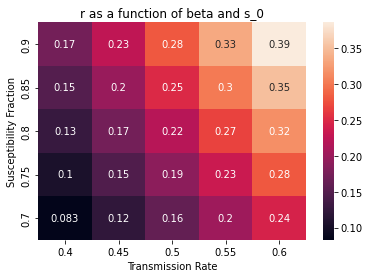

In [4]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 673   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model

def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    del_S = -beta*S*I/5100000 + R/180
    del_I = beta*S*I/5100000 -I/5 
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0)

growth_rates = []
for s in [0.9, 0.85, 0.8, 0.75, 0.7]:
    for beta in [0.4, 0.45, 0.5, 0.55, 0.6]:
        S0 = 5100000*s
        sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 100, beta], t_eval=range(final_date-initial_date+1))
        new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
        growth_rate = (new_incident_cases[1:] - new_incident_cases[:-1])/new_incident_cases[:-1]
        growth_rates.append([s, beta, np.mean(growth_rate)])
        #print(s, beta, np.mean(growth_rate))
        #reportable_cases = np.multiply(new_incident_cases, frac_test)

growth_rates = pd.DataFrame(np.array(growth_rates), columns=['Susceptibility Fraction', 'Transmission Rate', 'r'])
ax = sns.heatmap(growth_rates.pivot('Susceptibility Fraction', 'Transmission Rate', 'r'), annot=True)
ax.set_title('r as a function of beta and s_0')
ax.invert_yaxis()

2021-12-12 2022-02-15 361


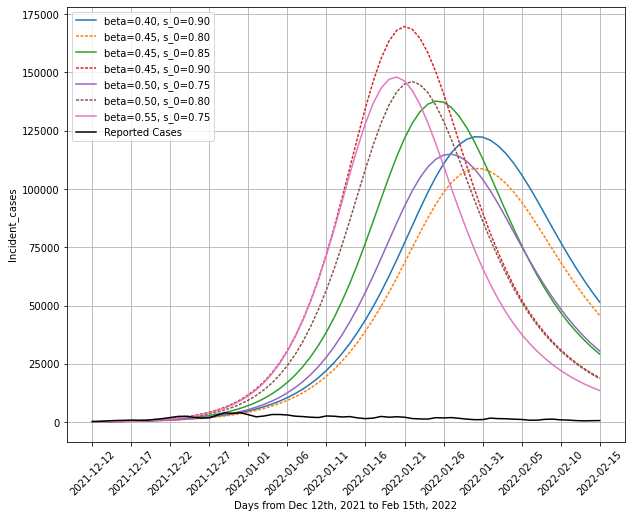

In [18]:
days = np.array(range(-8, 58))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 718   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model
plt.rcParams['figure.figsize'] = (10, 8)

def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    del_S = -beta*S*I/5100000 + R/180
    del_I = beta*S*I/5100000 -I/5 
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0)

parameters = [(0.4, 0.9), (0.45, 0.80), (0.45, 0.85), (0.45, 0.9), (0.5, 0.75), (0.5, 0.80), (0.55, 0.75)]
num = 0
for (beta, s) in parameters:
        S0 = 5100000*s
        sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 200, beta], t_eval=range(final_date-initial_date+1))
        new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
        reportable_cases = np.multiply(new_incident_cases, frac_test)
        if(num %2 == 0):
            plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, s_0=%.2f' % (beta, s))
        else:
            plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, s_0=%.2f' % (beta, s), linestyle='dashed', dashes=(2,1))
        num += 1


plt.plot(dates_of_interest, corresponding_cases, label='Reported Cases', color='black')
plt.xticks(dates_of_interest[::5], rotation=45)
plt.ylabel('Incident_cases')
plt.xlabel('Days from Dec 12th, 2021 to Feb 15th, 2022')
plt.grid()
plt.legend()
plt.show()

# Case Importations

A possible way to explain this is that case importations bloated the growth rate due to which the epidemic had a very big size.
Starting off with an extreme case that the number of infecteds remain 100 each day. 

2021-12-12 2022-02-15 361


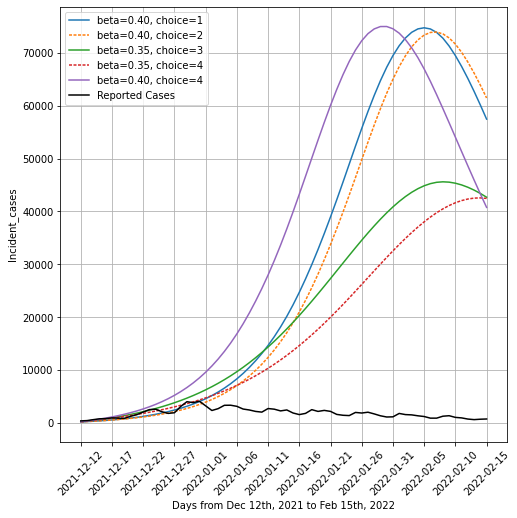

'"\ngrowth_rates = pd.DataFrame(np.array(growth_rates), columns=[\'Importation Choice\', \'Transmission Rate\', \'r\'])\nax = sns.heatmap(growth_rates.pivot(\'Importation Choice\', \'Transmission Rate\', \'r\'), annot=True)\nax.set_title(\'r as a function of beta and importation\')\nax.invert_yaxis()\n'

In [9]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 718   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model
plt.rcParams['figure.figsize'] = (8, 8)
def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    choice =  state[4]
    if(choice==1):
        additions = 100
    elif(choice==2):
        additions = 100*np.exp(-0.05*t)
    elif(choice==3):
        additions = 400
    else:
        additions = 400*np.exp(-0.05*t)    
    del_S = -beta*S*I/5100000 + R/180
    del_I = beta*S*I/5100000 -I/5 + additions
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0, 0)

growth_rates = []
num = 0
parameter_list = [(1, 0.40), (2, 0.40), (3, 0.35), (4, 0.35), (4, 0.40)]
for (choice, beta) in parameter_list:
    s = 0.8
    S0 = 5100000*s
    sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 100, beta, choice], t_eval=range(final_date-initial_date+1))
    new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
    growth_rate = (new_incident_cases[1:] - new_incident_cases[:-1])/new_incident_cases[:-1]
    growth_rates.append([choice, beta, np.mean(growth_rate)])
    #if(np.round(np.mean(growth_rate), 2)>=0.17 and np.round(np.mean(growth_rate), 2)<=0.23):
    if(num %2 == 0):
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, choice=%d' % (beta, choice))
    else:
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, choice=%d' % (beta, choice), linestyle='dashed', dashes=(2,1))
    #print(s, beta, np.mean(growth_rate))
    #reportable_cases = np.multiply(new_incident_cases, frac_test)
    num += 1

plt.plot(dates_of_interest, corresponding_cases, label='Reported Cases', color='black')
plt.xticks(dates_of_interest[::5], rotation=45)
plt.ylabel('Incident_cases')
plt.xlabel('Days from Dec 12th, 2021 to Feb 15th, 2022')
plt.grid()
plt.legend()
plt.show()
""""
growth_rates = pd.DataFrame(np.array(growth_rates), columns=['Importation Choice', 'Transmission Rate', 'r'])
ax = sns.heatmap(growth_rates.pivot('Importation Choice', 'Transmission Rate', 'r'), annot=True)
ax.set_title('r as a function of beta and importation')
ax.invert_yaxis()
"""

# Vaccinations

2021-12-12 2022-01-01 361


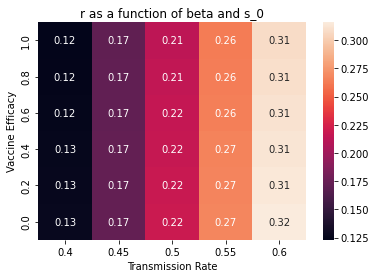

In [6]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 673   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model

def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    effic = state[4]
    if(t>14):
        b = (2555669-633831)/72
    else:
        b = 0
    del_S = -beta*S*I/5100000 + R/180 - b*effic
    del_I = beta*S*I/5100000 -I/5 
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0, 0)

growth_rates = []
for efficacy in [1, 0.8, 0.6, 0.4, 0.2, 0]:
    for beta in [0.4, 0.45, 0.5, 0.55, 0.6]:
        s = 0.8
        S0 = 5100000*s
        sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 100, beta, efficacy], t_eval=range(final_date-initial_date+1))
        new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
        growth_rate = (new_incident_cases[1:] - new_incident_cases[:-1])/new_incident_cases[:-1]
        growth_rates.append([efficacy, beta, np.mean(growth_rate)])
        #print(s, beta, np.mean(growth_rate))
        #reportable_cases = np.multiply(new_incident_cases, frac_test)

growth_rates = pd.DataFrame(np.array(growth_rates), columns=['Vaccine Efficacy', 'Transmission Rate', 'r'])
ax = sns.heatmap(growth_rates.pivot('Vaccine Efficacy', 'Transmission Rate', 'r'), annot=True)
ax.set_title('r as a function of beta and s_0')
ax.invert_yaxis()

2021-12-12 2022-02-15 361


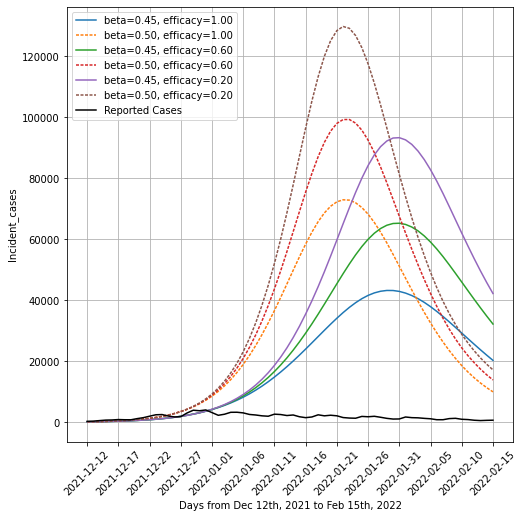

In [13]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date = 718   # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model
plt.rcParams['figure.figsize'] = (8, 8)
def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    effic = state[4]
    if(t>14):
        b = (2555669-633831)/72
    else:
        b = 0
    del_S = -beta*S*I/5100000 + R/180 - b*effic
    del_I = beta*S*I/5100000 -I/5 
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0, 0)

growth_rates = []
num = 0
parameter_list = [(1, 0.45), (1, 0.50), (0.6, 0.45), (0.6, 0.50), (0.2, 0.45), (0.2, 0.50)]
for (efficacy, beta) in parameter_list:
    s = 0.8
    S0 = 5100000*s
    sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 100, beta, efficacy], t_eval=range(final_date-initial_date+1))
    new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
    #growth_rate = (new_incident_cases[1:] - new_incident_cases[:-1])/new_incident_cases[:-1]
    #growth_rates.append([choice, beta, np.mean(growth_rate)])
    #if(np.round(np.mean(growth_rate), 2)>=0.17 and np.round(np.mean(growth_rate), 2)<=0.23):
    if(num %2 == 0):
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, efficacy=%.2f' % (beta, efficacy))
    else:
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, efficacy=%.2f' % (beta, efficacy), linestyle='dashed', dashes=(2,1))
    #print(s, beta, np.mean(growth_rate))
    #reportable_cases = np.multiply(new_incident_cases, frac_test)
    num += 1

plt.plot(dates_of_interest, corresponding_cases, label='Reported Cases', color='black')
plt.xticks(dates_of_interest[::5], rotation=45)
plt.ylabel('Incident_cases')
plt.xlabel('Days from Dec 12th, 2021 to Feb 15th, 2022')
plt.grid()
plt.legend()
plt.show()


# Vaccinations and Importations

2021-12-12 2022-02-15 361


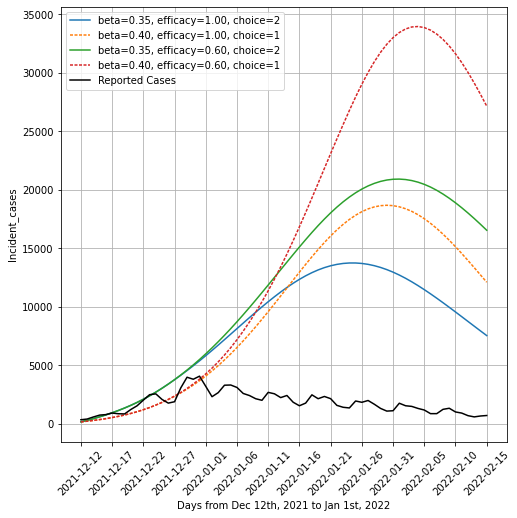

In [17]:
days = np.array(range(-8, 13))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

initial_date = 653 # Dec 12th, 2021
final_date =  718  # Jan 1st, 2022
dates_of_interest = case_dates[initial_date: final_date+1]
corresponding_cases = case_frequency[initial_date : final_date+1]
print(dates_of_interest[0], dates_of_interest[-1], corresponding_cases[0])
# Fitting SIRS Model
plt.rcParams['figure.figsize'] = (8, 8)
def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    effic = state[4]
    choice = state[5]
    if(choice==1):
        additions = 100
    else:
        additions = 400
    if(t>14):
        b = (2555669-633831)/72
    else:
        b = 0
    del_S = -beta*S*I/5100000 + R/180 - b*effic
    del_I = beta*S*I/5100000 -I/5 + additions
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0, 0, 0)

growth_rates = []
num = 0
parameter_list = [(1, 0.35, 2), (1, 0.40, 1), (0.6, 0.35, 2), (0.6, 0.40, 1)]
for (efficacy, beta, choice) in parameter_list:
    s = 0.8
    S0 = 5100000*s
    sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 180/(beta*0.8), 100, beta, efficacy, choice], t_eval=range(final_date-initial_date+1))
    new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
    #growth_rate = (new_incident_cases[1:] - new_incident_cases[:-1])/new_incident_cases[:-1]
    #growth_rates.append([choice, beta, np.mean(growth_rate)])
    #if(np.round(np.mean(growth_rate), 2)>=0.17 and np.round(np.mean(growth_rate), 2)<=0.23):
    if(num %2 == 0):
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, efficacy=%.2f, choice=%d' % (beta, efficacy, choice))
    else:
        plt.plot(dates_of_interest, new_incident_cases, label='beta=%.2f, efficacy=%.2f, choice=%d' % (beta, efficacy, choice), linestyle='dashed', dashes=(2,1))
    #print(s, beta, np.mean(growth_rate))
    #reportable_cases = np.multiply(new_incident_cases, frac_test)
    num += 1

plt.plot(dates_of_interest, corresponding_cases, label='Reported Cases', color='black')
plt.xticks(dates_of_interest[::5], rotation=45)
plt.ylabel('Incident_cases')
plt.xlabel('Days from Dec 12th, 2021 to Jan 1st, 2022')
plt.grid()
plt.legend()
plt.show()


2021-12-01 2022-03-10
368 293


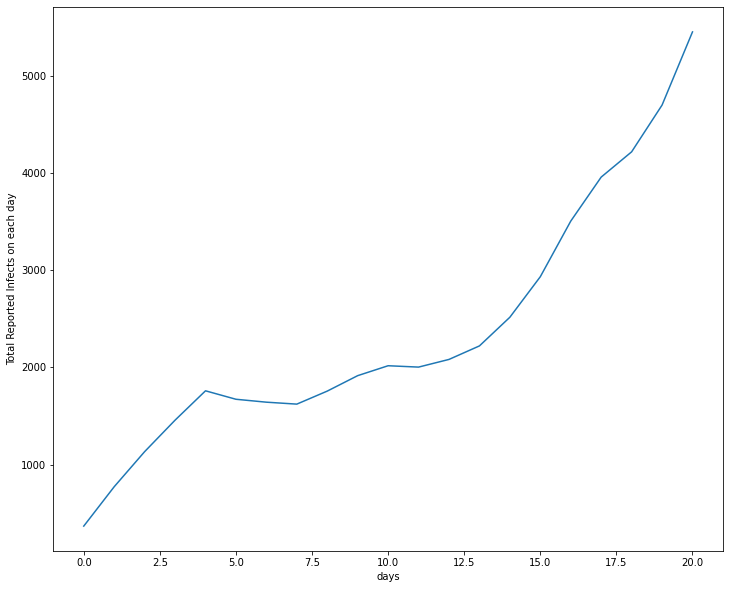

In [24]:
dates_of_interest =  case_dates[642: 742]  #642-742
corresponding_cases = case_frequency[642: 742]
print(dates_of_interest[0], dates_of_interest[-1])
print(corresponding_cases[0], corresponding_cases[-1])
#Calculating total infecteds (reported) in BC for each day between 1st November, 2021 to 31st March, 2022
total_reported_infecteds = [corresponding_cases[0]]
for j in range(1, 21):
    if(j>=5):
        total_reported_infecteds.append(corresponding_cases[j]+total_reported_infecteds[j-1]-corresponding_cases[j-5])
    else:
        total_reported_infecteds.append(total_reported_infecteds[j-1]+corresponding_cases[j])
plt.plot(total_reported_infecteds)
plt.xlabel('days')
plt.ylabel('Total Reported Infects on each day')
plt.show()

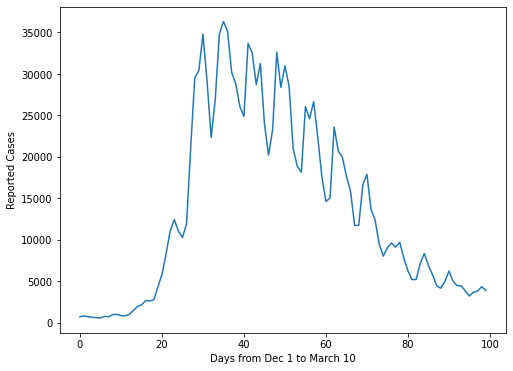

In [21]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(corresponding_cases)
plt.ylabel('Reported Cases')
plt.xlabel('Days from Dec 1 to March 10')
plt.show()

In [20]:
days = np.array(range(-19, 81))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

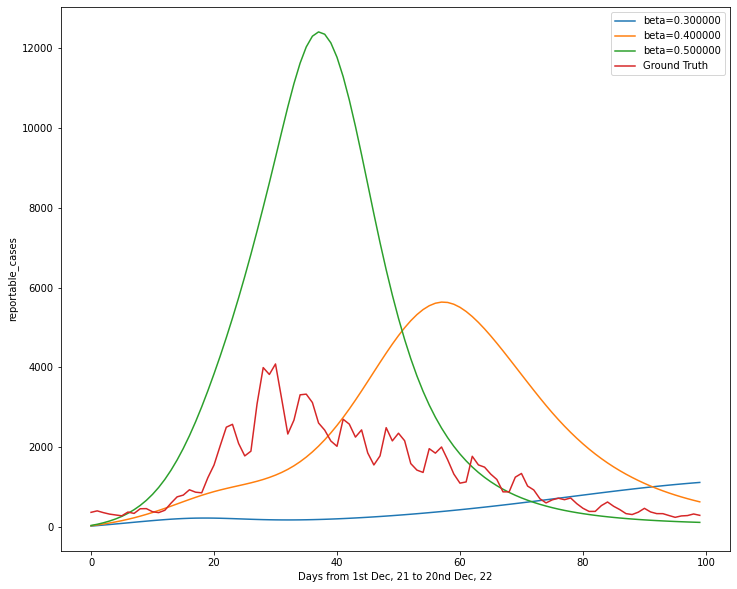

In [34]:
def SIRS_model(t, state):
    S = state[0]
    I = state[1]
    R = state[2]
    beta = state[3]
    del_S = -beta*S*I/5100000 + R/180
    del_I = beta*S*I/5100000 -I/5 + 100
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0)


plt.rcParams['figure.figsize'] = (12, 10)
for beta in [0.3, 0.4, 0.5]:
    S0 = 5100000*0.8
    sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 200, 600, beta], t_eval=range(101))
    new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
    reportable_cases = np.multiply(new_incident_cases[:-1], frac_test)
    plt.plot(reportable_cases, label='beta=%f' % beta)

plt.plot(corresponding_cases, label='Ground Truth')
plt.ylabel('reportable_cases')
plt.xlabel('Days from 1st Dec, 21 to 20nd Dec, 22')
plt.legend()
plt.show()

[]

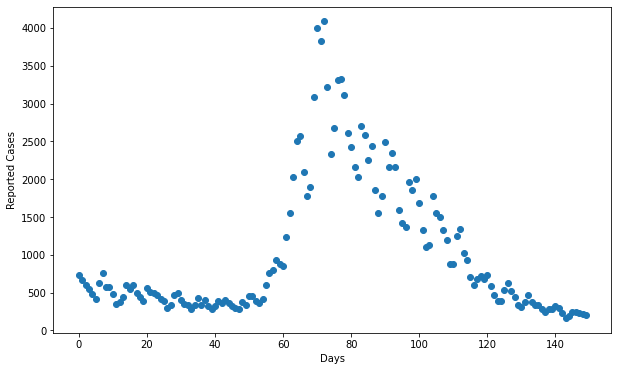

In [27]:
plt.rcParams['figure.figsize'] = (10,6)
plt.scatter(range(150), case_frequency[600:750])
plt.xlabel('Days')
plt.ylabel('Reported Cases')
plt.plot()

In [21]:
bc_covid_data['Reported_Date'].value_counts(sort=False).scatter()
plt.show()

AttributeError: 'Series' object has no attribute 'scatter'

151


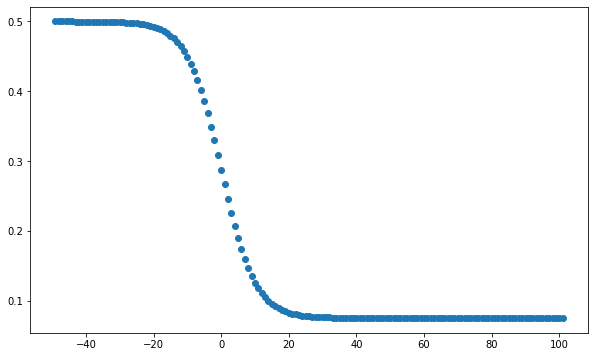

In [41]:

plt.scatter(days, frac)
plt.show()

# Vaccaniations

In [21]:
(633831/2201995)*50.9

14.651258472430682

In [26]:
(4150305/4485371)*0.9

0.8327682370087113

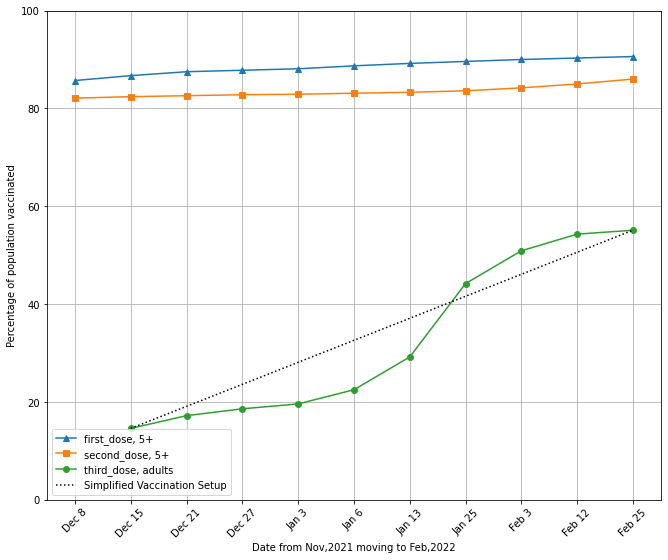

In [8]:
plt.rcParams['figure.figsize'] = (11, 9)
dates = ['Nov 04', 'Nov 19', 'Nov 30', 'Dec 8', 'Dec 15', 'Dec 21', 'Dec 27', 'Jan 3', 'Jan 6', 'Jan 13', 'Jan 25', 'Feb 3', 'Feb 12', 'Feb 25']
first_dose = [83.8, 84.4, 84.7, 85.7, 86.7, 87.5, 87.8, 88.1, 88.7, 89.2, 89.6, 90, 90.3, 90.6]
second_dose = [79.6, 80.9, 81.6, 82.1, 82.4, 82.6, 82.8, 82.9, 83.1, 83.3, 83.6, 84.2, 85, 86]
third_dose = ['na', 'na', 'na', 'na', 14.6, 17.2, 18.6, 19.6, 22.5, 29.2, 44.2, 50.9, 54.3, 55.1]

plt.plot(dates[3:], first_dose[3:], label='first_dose, 5+', marker='^')
plt.plot(dates[3:], second_dose[3:], label='second_dose, 5+', marker='s')
plt.plot(dates[4:], third_dose[4:], label='third_dose, adults', marker='o')
plt.plot([dates[4], dates[-1]], [14.6, 55.1], linestyle='dotted', color='black', label='Simplified Vaccination Setup' )
plt.ylim(bottom=0, top=100)
plt.xticks(rotation=45)
plt.ylabel('Percentage of population vaccinated')
plt.xlabel('Date from Nov,2021 moving to Feb,2022')
plt.legend()
plt.grid()
plt.show()

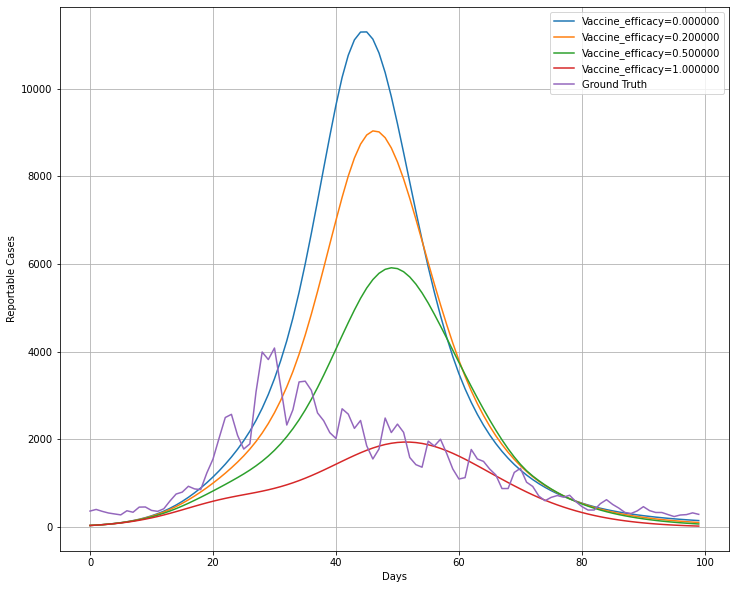

In [37]:
# Vaccination modelling
nu = 1 #vaccine efficacy
b = (2555669-633831)/72 # constant rate at which people are being vaccinated
days = np.array(range(-19, 81))
frac_test = 0.5*(1-(0.85/(1+np.exp(-0.2*days))))

def SIRS_model(t, state):
    b = (2555669-633831)/72
    S = state[0]
    I = state[1]
    R = state[2]
    nu = state[3]
    del_S = -0.5*S*I/5100000 + R/180 -b*nu
    del_I = 0.5*S*I/5100000 -I/5
    del_R = I/5 - R/180
    return (del_S, del_I, del_R, 0)


plt.rcParams['figure.figsize'] = (12, 10)
for nu in [0, 0.2, 0.5, 1]:
    beta = 0.5
    S0 = 5100000*0.8
    sol = solve_ivp(fun=SIRS_model, t_span=[0, 150], y0=[S0, 200, 500, nu], t_eval=range(101))
    new_incident_cases = beta*np.multiply(sol.y[0], sol.y[1])//5100000
    reportable_cases = np.multiply(new_incident_cases[:-1], frac_test)
    plt.plot(reportable_cases, label='Vaccine_efficacy=%f' % nu)

plt.plot(corresponding_cases, label='Ground Truth')
plt.xlabel('Days')
plt.ylabel('Reportable Cases')
plt.legend()
plt.grid()
plt.show()